# Handling the log files : solution to exercise on N2 molecule 

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA and the HF run.
Change the values of the *hgrid* and *crmult* to find the converged values. Note that a thorough description of those two (essential) parameters is provided later on when studying a [CH4 molecule](./CH4.ipynb).

Note that, both in the LDA and in the HF calculation, a norm-conserving PSP is used.

The results can be compared to all-electron calculations, done with different basis sets, from references (units are eV)
(1) S.&nbsp;Hamel <i>et&nbsp;al.</i> J. Electron Spectrospcopy and Related Phenomena 123 (2002) 345-363 and (2) P.&nbsp;Politzer, F.&nbsp;Abu-Awwad, Theor. Chem. Acc. (1998), 99, 83-87:

eigenvalues          | LDA(1) | HF(1) | HF(2) | (Exp.)
---------------------|--------|-------|-------|-------
3&sigma;<sub>g</sub> | 10.36  | 17.25 | 17.31 | (15.60)
1&pi;<sub>u</sub>    | 11.84  | 16.71 | 17.02 | (16.98)
2&sigma;<sub>u</sub> | 13.41  | 21.25 | 21.08 | (18.78)
 
The results depends, of course, on the precision chosen for the calculation, and of the presence of the pseudopotential.
As it is well-known, the pseudopotential appoximation is however much less severe than the approximation induced by typical XC functionals. We might see that, even in the HF case, the presence of a LDA-based pseudopotential (of rather good quality) does not alter so much the results. 

Here you can find the values from BigDFT calculation using a very good precision (*hgrid=0.3*, *crmult=7.0*). 
Note that 1 Ha=27.21138386 eV.

eigenvalues          | LDA    | HF
---------------------|--------|------
3&sigma;<sub>g</sub> | 10.41  | 16.82
1&pi;<sub>u</sub>    | 11.88  | 17.37
2&sigma;<sub>u</sub> | 13.42  | 21.18

How much do these values differ from the calculation with default parameters? Do they converge to a given value?
What is the *correlation* for the N2 molecule in (PSP) LDA?

In [1]:
install = "client (Google drive)" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

Mounted at /content/drive
Executing: mkdir -p /content/drive/MyDrive

Executing: git clone --depth 1 https://github.com/BigDFT-group/bigdft-school
Error Occurred:  
 fatal: destination path 'bigdft-school' already exists and is not an empty directory.

Executing: mkdir -p /content/drive/MyDrive/bigdft-school



In [21]:
install.data('data/session1.tar.xz')

In [3]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.IO import XYZReader

N2 = System()
with XYZReader("N2") as ifile:
    N2["N:0"] = Fragment(xyzfile=ifile)

In [23]:
from BigDFT.Calculators import SystemCalculator
from BigDFT.Logfiles import Logfile
from BigDFT.Inputfiles import Inputfile

HtoeV = 27.21138386 #Conversion Hartree to meV

inp = Inputfile()
inp['psppar.N']={'Pseudopotential XC': 1}
study = SystemCalculator(skip=True, verbose=False) #Create a calculator

#Run the code with the name scheme LDA
inp.set_xc('LDA')
LDA = study.run(input=inp, name="LDA",posinp=N2.get_posinp(), run_dir="scratch") 

#Run the code with the name scheme HF
inp.set_xc('HF')
HF = study.run(input=inp, name="HF",posinp=N2.get_posinp(), run_dir="scratch")

#Run the code with the name scheme HF 
inp.set_xc('PBE0')
PBE0 = study.run(input=inp, name="PBE0",posinp=N2.get_posinp(), run_dir="scratch") 

The variables *first*, *LDA*, *HF* and *PBE0* are instances of the class *BigDFT.Logfiles.Logfile* which contain all information as the total energy.
We should also use directly this call loading the corresponding output file as

In [24]:
PBE0 = Logfile("scratch/log-PBE0.yaml")

We compare the values for LDA and HF.

In [25]:
from pandas import DataFrame, options

df = DataFrame(columns=["eigenvalues", "LDA", "HF"])
options.display.float_format = '{:,.2f}'.format

lda_evals = LDA.evals[0][0]
hf_evals = HF.evals[0][0]

df.loc[0] = ["3$\sigma_g$", lda_evals[-1]*HtoeV, hf_evals[-1]*HtoeV]
df.loc[1] = ["1$\pi_u$", lda_evals[-3]*HtoeV, hf_evals[-3]*HtoeV]
df.loc[2] = ["2$\sigma_u$", lda_evals[-4]*HtoeV, hf_evals[-4]*HtoeV]

display(df)

,eigenvalues,LDA,HF
0,3$\sigma_g$,-10.39,-16.80
1,1$\pi_u$,-11.86,-17.36
2,2$\sigma_u$,-13.41,-21.17


## Modifications of the calculation parameters
Then we do a convergence curve varying *hgrid* which controls the grid step of the Daubechies basis set and *crmult* the extension. The default values are:

In [26]:
print('hgrids',LDA.log['dft']['hgrids'])
print('rmult',LDA.log['dft']['rmult'])

hgrids [0.45, 0.45, 0.45]
rmult [5.0, 8.0]


*hgrids* is an array of 3 values for the x, y, and z direction. A simple scalar can be indicated for the input.
*rmult* is composed into two multiplied factors, one for the coarse grid, and the second one for the fine grid.
We build our script for LDA and run it (on one core, it takes 10 minutes roughly for all calculations).

In [28]:
Hgrids = [0.45, 0.40, 0.35, 0.30, 0.25]
Crmult = [3.0, 5.0, 7.0, 9.0]
log_LDA = {}

inp.set_xc('LDA')

emin_LDA = 0.0
for crmult in Crmult:
    log_LDA[crmult] = []
    for hgrid in Hgrids:
        inp.set_hgrid(hgrid)
        inp['dft']['rmult'] = [ crmult, 8.0]
        name = "LDA-%4.2f-%04.1f" % (hgrid,crmult)
        log = study.run(input=inp, name=name, posinp=N2.get_posinp(), run_dir="scratch")
        log_LDA[crmult].append( log )
        emin_LDA =min(emin_LDA,log.energy)

We do the same loops to run the Hartree-Fock calculations.

In [29]:
log_HF = {}
inp.set_xc("HF")

emin_HF = 0.0
for crmult in Crmult:
    log_HF[crmult] = []
    for hgrid in Hgrids:
        inp.set_hgrid(hgrid)
        inp['dft']['rmult'] = [ crmult, 8.0]
        name = "HF-%4.2f-%04.1f" % (hgrid,crmult)
        log = study.run(input=inp, name=name, posinp=N2.get_posinp(), run_dir="scratch")
        log_HF[crmult].append(log)
        emin_HF = min(emin_HF,log.energy)

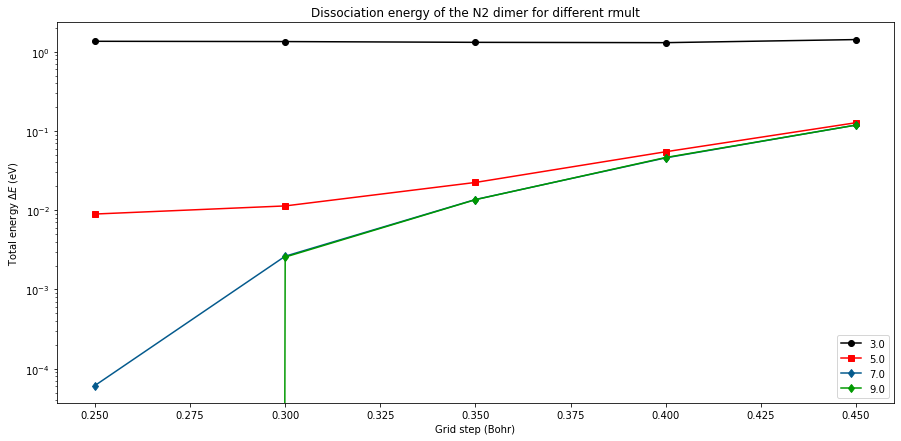

In [30]:
import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i,crmult in enumerate(Crmult):
    im = i%len(colors)
    ener = [ HtoeV*(l.energy-emin_LDA) for l in log_LDA[crmult] ]
    plt.plot(Hgrids, ener, marker=markers[im], 
             ls='-', label=str(crmult),color=colors[im])  

plt.yscale('log')
plt.xlabel('Grid step (Bohr)')
plt.ylabel('Total energy $\Delta E$ (eV)')
plt.title('Dissociation energy of the N2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

In order to converge the result, you need to decrease the grid step and also increase the extension of the mesh. For a given *crmult*, the curve are almost flat. For a *hgrid* value of of 0.35, there is few difference between the values with *crmult*=5.0 and 7.0 but for a *hgrid* value of 0.20 it is important. Now we give the HOMO-1 and HOMO eigenvalues both for LDA and HF functionals

In [32]:
ih = Hgrids.index(0.3)
lda_evals = log_LDA[7.0][ih].evals[0][0]
hf_evals = log_HF[7.0][ih].evals[0][0]
    
df = DataFrame(columns=["LDA", "HF"])
for idx, (l,h) in enumerate(zip(reversed(lda_evals),reversed(hf_evals))):
    df.loc[idx] = [-HtoeV*l, -HtoeV*h]
    
display(df)

,LDA,HF
0,10.41,16.82
1,11.88,16.82
2,11.88,17.37
3,13.42,21.18
4,28.35,40.21
